In [224]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [225]:
train_df = pd.read_csv('..\dataset\indore_water_supply_train.csv')
validation_df = pd.read_csv('..\dataset\indore_water_supply_validation.csv')
test_df = pd.read_csv('..\dataset\indore_water_supply_test.csv')
train_df['Consumption_per_Person'] = train_df['Water Consumption (liters)'] / train_df['Household Size']
validation_df['Consumption_per_Person'] = validation_df['Water Consumption (liters)'] / validation_df['Household Size']
test_df['Consumption_per_Person'] = test_df['Water Consumption (liters)'] / test_df['Household Size']

In [235]:
features = ["Water Consumption (liters)", "Household Size", "Pressure (bar)", "Temperature (C)",'Consumption_per_Person']

X_train = train_df[features]
X_val = validation_df[features]
y_val = validation_df["Anomaly"]
X_test = test_df[features]
y_test = test_df["Anomaly"]

In [236]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [244]:
iso_forest = IsolationForest(contamination=0.07, random_state=42)
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.07, random_state=42)

In [245]:
val_predictions = iso_forest.predict(X_val_scaled)
val_predictions = [1 if pred == -1 else 0 for pred in val_predictions]  # Convert -1 to 1 and 1 to 0

test_predictions = iso_forest.predict(X_test_scaled)
test_predictions = [1 if pred == -1 else 0 for pred in test_predictions]  # Convert -1 to 1 and 1 to 0

In [246]:
val_scores = iso_forest.decision_function(X_val_scaled)
scaler = MinMaxScaler()
val_scores_scaled = scaler.fit_transform(val_scores.reshape(-1, 1))
threshold = 0.3
val_predictions = (val_scores_scaled < threshold).astype(int)

In [247]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_predictions = lof.fit_predict(X_val_scaled)
lof_predictions = [1 if pred == -1 else 0 for pred in lof_predictions]

svm = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.1)
svm.fit(X_train_scaled)
svm_predictions = svm.predict(X_val_scaled)
svm_predictions = [1 if pred == -1 else 0 for pred in svm_predictions]

# Ensemble voting (majority vote)
ensemble_predictions = [1 if (iso_pred + lof_pred + svm_pred) >= 2 else 0 
                        for iso_pred, lof_pred, svm_pred in zip(val_predictions, lof_predictions, svm_predictions)]


In [248]:
f1_val = f1_score(y_val, ensemble_predictions)
accuracy_val = accuracy_score(y_val, ensemble_predictions)
precision_val = precision_score(y_val, ensemble_predictions)
recall_val = recall_score(y_val, ensemble_predictions)

print(f"Validation F1 Score: {f1_val}")
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

print("\nClassification Report on Validation Set:")
print(classification_report(y_val, val_predictions))


Validation F1 Score: 0.49612403100775193
Validation Accuracy: 0.935
Validation Precision: 0.3950617283950617
Validation Recall: 0.6666666666666666

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       0.96      1.00      0.98        48

    accuracy                           1.00      1000
   macro avg       0.98      1.00      0.99      1000
weighted avg       1.00      1.00      1.00      1000



In [249]:
# Evaluate the model on test set
f1_test = f1_score(y_test, test_predictions)
accuracy_test = accuracy_score(y_test, test_predictions)
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)

print(f"Test F1 Score: {f1_test}")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")

print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_predictions))

Test F1 Score: 0.8376068376068375
Test Accuracy: 0.981
Test Precision: 0.7205882352941176
Test Recall: 1.0

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       951
           1       0.72      1.00      0.84        49

    accuracy                           0.98      1000
   macro avg       0.86      0.99      0.91      1000
weighted avg       0.99      0.98      0.98      1000



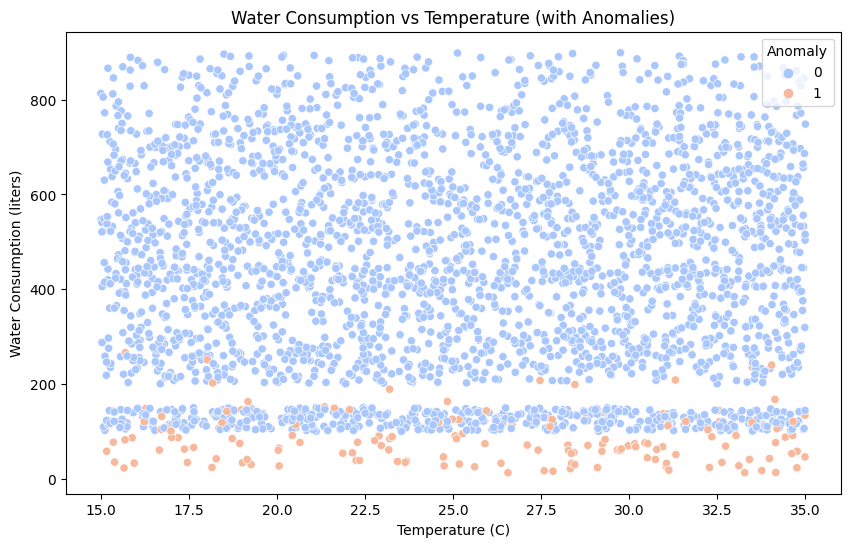

In [250]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x="Temperature (C)", y="Water Consumption (liters)", hue="Anomaly", palette="coolwarm")
plt.title("Water Consumption vs Temperature (with Anomalies)")
plt.xlabel("Temperature (C)")
plt.ylabel("Water Consumption (liters)")
plt.show()